In [1]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# visualization
with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
    data = json.load(f)

cuda


In [2]:
# %%
timestep = 0.01
assert(data['time'][1] - data['time'][0] - timestep < 0.001)
x = torch.tensor(data['x'])
y = torch.tensor(data['y'])
yaw = torch.tensor(data['yaw'])
vx = torch.tensor(data['vx'])
vy = torch.tensor(data['vy'])
yaw_rate = torch.tensor(data['yaw_rate'])
steer_angle = torch.tensor(data['steer_angle'])
drive_force = torch.tensor(data['drive_force'])
steer_speed = torch.tensor(data['steer_speed'])

In [3]:
# %%
initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([drive_force, steer_speed]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
target_states = output_states[1:]
target_states = target_states.contiguous().to(DEVICE)

print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([22486, 2]) | States size: torch.Size([22486, 7])


In [4]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=50
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([2243, 50, 2]) | Batched States size: torch.Size([2243, 50, 7])


In [5]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [6]:
# %%
params = {
    # axes distances
    'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # moments of inertia of sprung mass
    # masses
    'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    'mass': 1225.887,  # vehicle mass [kg]  MASS

    # Pacejka tire force parameters
    'Df': 3709.08227,  # [rad/m]  DF
    'Cf': 1.3507,
    'Bf': 16.2216,
    'Dr': 3709.08227,  # [rad/m]  DR
    'Cr': 1.3507,
    'Br': 16.2216,
    'Cm': 0.3777,
    'Cr0': 2.1469,
    'Cr2': 0.0,
}
params.update({
    "lf" : 0.8839200139045715,
    "lr" : 1.5087599754333496,
    "Iz" : 1771.53857421875,
    "mass" : 701.0275268554688,
    "Df" : 4041.601318359375,
    "Cf" : 1.4304611682891846,
    "Bf" : 18.741268157958984,
    "Dr" : 3652.13427734375,
    "Cr" : 0.7047927379608154,
    "Br" : 27.620542526245117,
    "Cm" : 0.5324415564537048,
    "Cr0" : 10.995059967041016,
    "Cr2" : -0.03063417412340641,
})
dynamics = DynamicBicycle(**params)
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
dynamics.lf.requires_grad = False
dynamics.lr.requires_grad = False
dynamics.mass.requires_grad = True
dynamics.Iz.requires_grad = True
dynamics.Df.requires_grad = True
dynamics.Cf.requires_grad = True
dynamics.Bf.requires_grad = True
dynamics.Dr.requires_grad = True
dynamics.Cr.requires_grad = True
dynamics.Br.requires_grad = True
dynamics.Cm.requires_grad = True
dynamics.Cr0.requires_grad = True
dynamics.Cr2.requires_grad = True
# <----                         ---->
euler_integrator = Euler(dynamics, timestep=timestep)
euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, timestep=timestep)
rk4_integrator.to(DEVICE)


RK4(
  (dynamics): DynamicBicycle()
)

In [7]:
with torch.no_grad():
    euler_output_states = euler_integrator(initial_state, control_inputs)


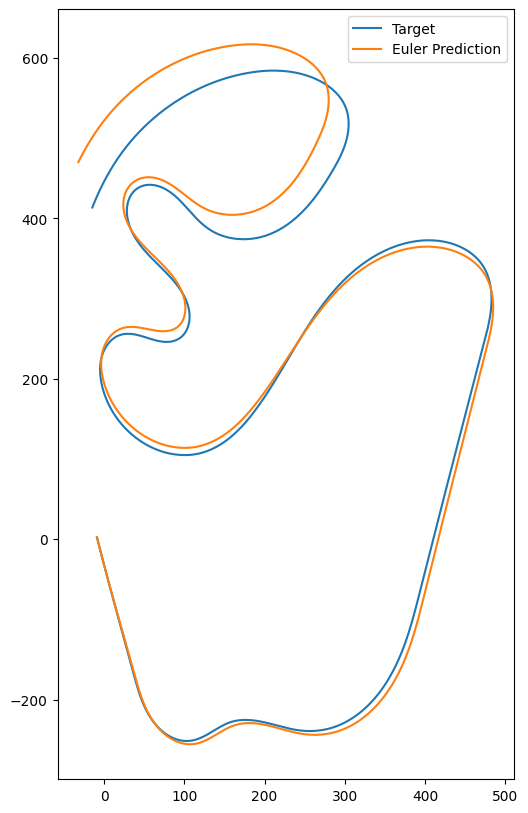

In [8]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(euler_output_states[:LEN, 0].detach().cpu().numpy(), euler_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
#ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [9]:
# %%
from tqdm.auto import tqdm
EPOCHS = 100
integrator = euler_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

with torch.no_grad():
        output_states = integrator(initial_state, control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets in dataloader:
        optimizer.zero_grad()
        output_states = integrator(initial, inputs)
        loss = torch.nn.functional.l1_loss(output_states, targets)
        loss.backward()
        optimizer.step()
    #for name, param in integrator.named_parameters():
    #    if param.requires_grad:
    #        print(name, param.data, param.grad)
    if i%20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs)
            val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        LEN=20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    with torch.no_grad():
        output_states = integrator(batched_initial_states,batched_control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())
    print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


Initialized | Validation Loss: 5.1003217697143555 | LR: 1


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 0.00999580416828394 | Validation Loss: 0.013597053475677967 | LR: 1
Epoch: 1 | Training Loss: 0.010601605288684368 | Validation Loss: 0.013432963751256466 | LR: 1
Epoch: 2 | Training Loss: 0.023422975093126297 | Validation Loss: 0.01341894268989563 | LR: 1
Epoch: 3 | Training Loss: 0.018580827862024307 | Validation Loss: 0.013416687957942486 | LR: 1
Epoch: 4 | Training Loss: 0.013885339722037315 | Validation Loss: 0.013401253148913383 | LR: 1
Epoch: 5 | Training Loss: 0.006619959603995085 | Validation Loss: 0.013403999619185925 | LR: 1
Epoch: 6 | Training Loss: 0.012864012271165848 | Validation Loss: 0.013401745818555355 | LR: 1
Epoch: 7 | Training Loss: 0.00854161474853754 | Validation Loss: 0.013400273397564888 | LR: 1
Epoch: 8 | Training Loss: 0.018501369282603264 | Validation Loss: 0.01340305432677269 | LR: 1
Epoch: 9 | Training Loss: 0.01796022802591324 | Validation Loss: 0.013401735574007034 | LR: 1
Epoch: 10 | Training Loss: 0.015301425009965897 | Valid

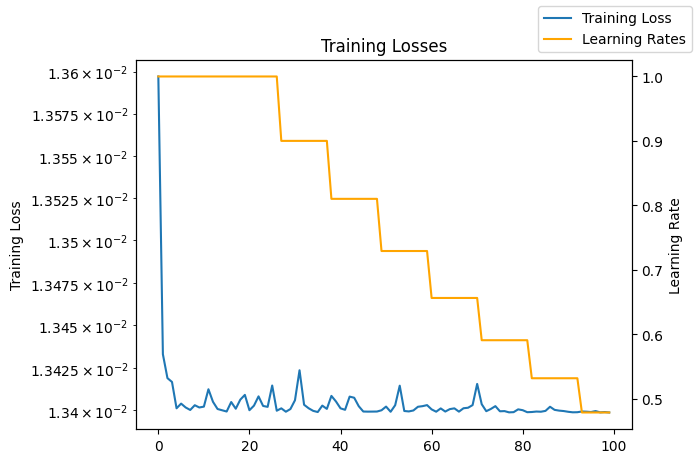

In [10]:
fig, ax = plt.subplots()
ax.plot(losses, label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
#secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [11]:
# %%
with torch.no_grad():
    output_states = integrator(initial_state, control_inputs)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

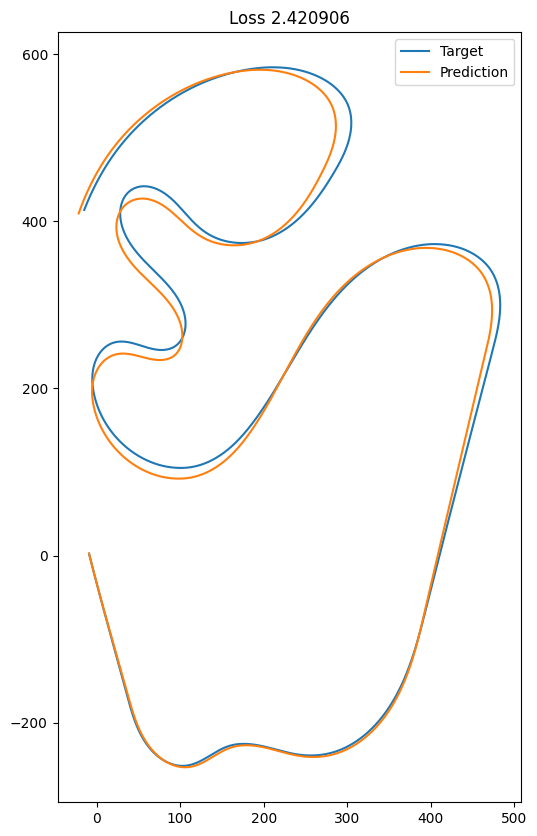

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
ax.set_aspect(1.0)
ax.legend()
ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.show()

In [13]:
print("{")
for key in dynamics.state_dict().keys():
    print(f"\t\"{key}\" : {dynamics.state_dict()[key]},")
print("}")

{
	"lf" : 0.8839200139045715,
	"lr" : 1.5087599754333496,
	"Iz" : 1771.53857421875,
	"mass" : 701.0275268554688,
	"Df" : 4041.601318359375,
	"Cf" : 1.5152722597122192,
	"Bf" : 18.74931526184082,
	"Dr" : 3652.13427734375,
	"Cr" : 0.7171155214309692,
	"Br" : 27.630693435668945,
	"Cm" : 0.5488027334213257,
	"Cr0" : 10.983186721801758,
	"Cr2" : -0.042967550456523895,
}
